In [1]:
import numpy as np
import math
import random
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
import glob
import gc
from utils import *
from tqdm import tqdm
import pickle

from keras.optimizers import *
from keras.models import Model
from keras.layers import *
from keras.layers.core import *
from keras.layers.convolutional import *
from keras import backend as K
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
tf.enable_eager_execution()

import numpy
import tensorflow
import tensorflow.keras as keras
import pickle
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, GlobalMaxPool2D, GlobalAveragePooling2D, BatchNormalization, SpatialDropout2D, LeakyReLU, Conv2D, AveragePooling2D, Dropout, Flatten, Lambda, Dense, MaxPooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.backend import expand_dims
from tensorflow.keras.optimizers import Adam
from matplotlib import pyplot as plt

from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping

from numpy.random import seed
seed(1)
tensorflow.random.set_seed(1)


Using TensorFlow backend.


Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [3]:
random.seed(123)

class Config():
    def __init__(self):
        self.frame_l = 32 # the length of frames
        self.joint_n = 12 # the number of joints
        self.joint_n = 22#43#22 # the number of joints
        self.joint_d = 3 # the dimension of joints
        self.clc_coarse = 14#28#14 # the number of coarse class
        self.clc_fine = 28 # the number of fine-grained class
        self.feat_d = 231
        self.filters = 16#32#16
        self.data_dir = 'E:\Skelnet2D\data\SHREC\\'
C = Config()

In [4]:
# model
dropout_probability = 0.1
duration = 32
n_classes = 28
n_channels = 22  # usually  n_channels = 2 * n_joints  or  n_channels = 3 * n_joints
filters = 16

In [5]:
def c2D(x,filters,kernel):
    x = Conv2D(filters, kernel_size=kernel,padding='same',use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = SpatialDropout2D(dropout_probability)(x)
    return x

def block(x,filters):
    x = c2D(x,filters,3)
    x = c2D(x,filters,3)
    return x
    
def d2D(x,filters):
    x = Dense(filters,use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    return x

In [6]:
def create_model(n_classes, duration, n_channels, dropout_probability=0.2):
    model_input = Input(shape=(duration, n_channels,3))
    
    high = c2D(model_input, filters*2,7)
    high = AveragePooling2D((2, 2), padding='same')(high)
    high = c2D(high, filters*2,7)
    high = AveragePooling2D((2, 2), padding='same')(high)
    high = c2D(high, filters*2,7)
    high = MaxPooling2D((2, 2), padding='same')(high)
    
    low = c2D(model_input, filters*2,3)
    low = AveragePooling2D((2, 2), padding='same')(low)
    low = c2D(low, filters*2,3)
    low = AveragePooling2D((2, 2), padding='same')(low)
    low = c2D(low, filters*2,3)
    low = AveragePooling2D((2, 2), padding='same')(low)
    
    ap_residual = AveragePooling2D((2, 2), padding='same', input_shape=(32,n_channels, 1))(model_input)
    ap_residual = AveragePooling2D((2, 2), padding='same')(ap_residual)
    ap_residual = AveragePooling2D((2, 2), padding='same')(ap_residual)
    
    channel_output = concatenate([low,high,ap_residual])
    features = block(channel_output,filters*2)
    features = block(channel_output,filters*2)
    features = GlobalAveragePooling2D()(features)
    features = d2D(features,128)
    features = Dropout(dropout_probability)(features)
    features = d2D(features,128)
    features = Dropout(dropout_probability)(features)
    model_output = Dense(units=n_classes, activation='softmax')(features)
        
    model = Model(inputs=[model_input], outputs=[model_output])
    return model

In [7]:
model = create_model(n_classes=n_classes, duration=duration, n_channels=n_channels, dropout_probability=dropout_probability)

In [8]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 22, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 32, 22, 64)   1728        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 22, 64)   9408        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_3 (BatchNor (None, 32, 22, 64)   256         conv2d_3[0][0]                   
______________________________________________________________________________________________

__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 4, 3, 64)     36864       spatial_dropout2d_8[0][0]        
__________________________________________________________________________________________________
batch_normalization_9 (BatchNor (None, 4, 3, 64)     256         conv2d_9[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_9 (LeakyReLU)       (None, 4, 3, 64)     0           batch_normalization_9[0][0]      
__________________________________________________________________________________________________
spatial_dropout2d_9 (SpatialDro (None, 4, 3, 64)     0           leaky_re_lu_9[0][0]              
__________________________________________________________________________________________________
global_average_pooling2d (Globa (None, 64)           0           spatial_dropout2d_9[0][0]        
__________

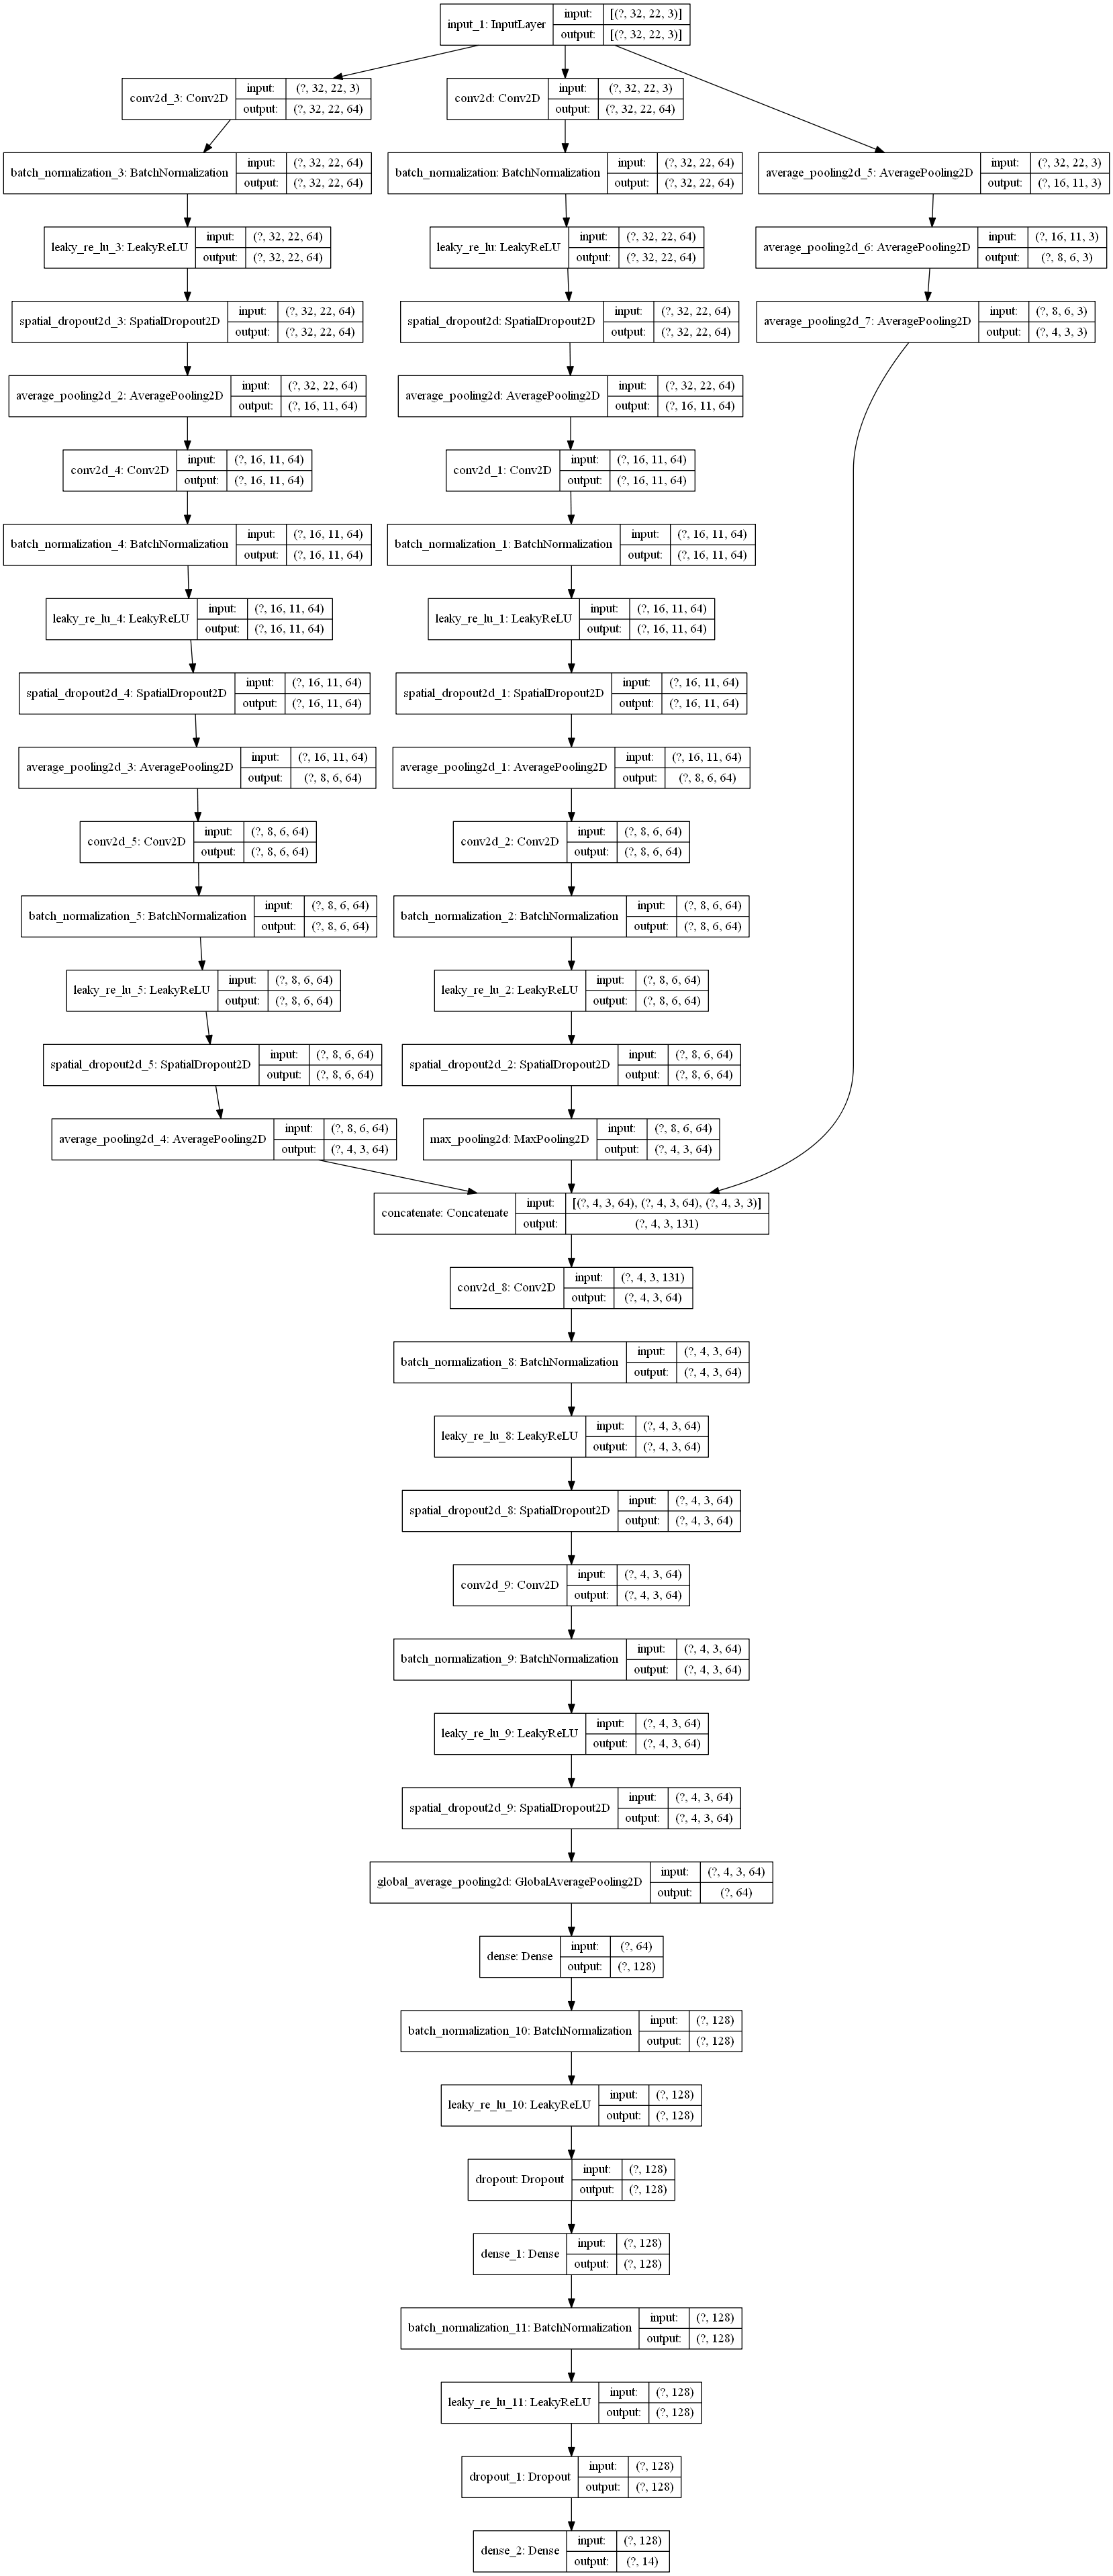

In [9]:
plot_model(model, to_file='model.png', show_shapes=True)

In [10]:
Train = pickle.load(open(C.data_dir+"train.pkl", "rb"))
Test = pickle.load(open(C.data_dir+"test.pkl", "rb"))

In [11]:
X_0 = []
X_1 = []
Y = []
for i in tqdm(range(len(Train['pose']))): 
    p = np.copy(Train['pose'][i]).reshape([-1,22,3])
    p = zoom(p,target_l=C.frame_l,joints_num=C.joint_n,joints_dim=C.joint_d)
    p = normlize_range(p)
    
    label = np.zeros(C.clc_coarse)
    label[Train['coarse_label'][i]-1] = 1   

    M = get_CG(p,C)

    X_0.append(M)
    X_1.append(p)
    Y.append(label)

X_0 = np.stack(X_0)  
X_1 = np.stack(X_1) 
Y = np.stack(Y)

  1%|▊                                                                              | 20/1960 [00:00<00:09, 198.51it/s]C:\Users\Joseph\Anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:611: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
100%|█████████████████████████████████████████████████████████████████████████████| 1960/1960 [00:09<00:00, 206.42it/s]


In [12]:
X_test_0 = []
X_test_1 = []
Y_test = []
for i in tqdm(range(len(Test['pose']))): 
    p = np.copy(Test['pose'][i]).reshape([-1,22,3])
    p = zoom(p,target_l=C.frame_l,joints_num=C.joint_n,joints_dim=C.joint_d)
    p = normlize_range(p)
    
    label = np.zeros(C.clc_coarse)
    label[Test['coarse_label'][i]-1] = 1   

    M = get_CG(p,C)

    X_test_0.append(M)
    X_test_1.append(p)
    Y_test.append(label)

X_test_0 = np.stack(X_test_0) 
X_test_1 = np.stack(X_test_1)  
Y_test = np.stack(Y_test)

100%|███████████████████████████████████████████████████████████████████████████████| 840/840 [00:04<00:00, 207.28it/s]


In [13]:
"""blank = X_1
blank_test = X_test_1
blank = np.zeros((1960,32,43,3))
blank_test = np.zeros((840,32,43,3))
list = [2,3,4,5,6,5,4,3,2,7,8,9,10,9,8,7,2,1,2,11,12,13,14,13,12,11,2,15,16,17,18,17,16,15,2,19,20,21,22,21,20,19,2]
count = 0
for i in range(0,X_1.shape[0]):
    for j in range(0, X_1.shape[1]):
        count = 0
        for k in list:
            blank[i][j][count] = X_1[i][j][k-1]
            count = count + 1
count = 0
for i in range(0, X_test_1.shape[0]):
    for j in range(0, X_test_1.shape[1]):
        count = 0
        for k in list:
            blank_test[i][j][count] = X_test_1[i][j][k-1]
            count = count + 1
X_1 = blank
X_test_1 = blank_test"""

'blank = X_1\nblank_test = X_test_1\nblank = np.zeros((1960,32,43,3))\nblank_test = np.zeros((840,32,43,3))\nlist = [2,3,4,5,6,5,4,3,2,7,8,9,10,9,8,7,2,1,2,11,12,13,14,13,12,11,2,15,16,17,18,17,16,15,2,19,20,21,22,21,20,19,2]\ncount = 0\nfor i in range(0,X_1.shape[0]):\n    for j in range(0, X_1.shape[1]):\n        count = 0\n        for k in list:\n            blank[i][j][count] = X_1[i][j][k-1]\n            count = count + 1\ncount = 0\nfor i in range(0, X_test_1.shape[0]):\n    for j in range(0, X_test_1.shape[1]):\n        count = 0\n        for k in list:\n            blank_test[i][j][count] = X_test_1[i][j][k-1]\n            count = count + 1\nX_1 = blank\nX_test_1 = blank_test'

In [14]:
# Training: Optimizer's Learning Rate
learning_rate = 0.001

# We use Adam to optimize a multi-class classification task
optimizer = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
loss = 'categorical_crossentropy'
metrics = ['accuracy']
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [15]:
# Start the training

# ...with an existing validation set:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=10, min_lr=1e-8)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
mc = ModelCheckpoint('best_model_Skel2D.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
history = model.fit(X_1, Y, validation_data=(X_test_1, Y_test), epochs=10000, batch_size=32, callbacks=[reduce_lr,es,mc])

# ...or, if there is no validation set:
# history = model.fit(x_train, y_train, validation_split=0.33, epochs=100, batch_size=32)

Train on 1960 samples, validate on 840 samples
Epoch 1/10000
1952/1960 [============================>.] - ETA: 1:38 - loss: 3.1377 - acc: 0.093 - ETA: 51s - loss: 2.7965 - acc: 0.125 - ETA: 35s - loss: 2.6874 - acc: 0.13 - ETA: 27s - loss: 2.5381 - acc: 0.16 - ETA: 22s - loss: 2.4395 - acc: 0.20 - ETA: 19s - loss: 2.3333 - acc: 0.23 - ETA: 17s - loss: 2.2785 - acc: 0.26 - ETA: 15s - loss: 2.2297 - acc: 0.28 - ETA: 14s - loss: 2.1776 - acc: 0.29 - ETA: 13s - loss: 2.1326 - acc: 0.31 - ETA: 12s - loss: 2.0865 - acc: 0.32 - ETA: 11s - loss: 2.0704 - acc: 0.33 - ETA: 10s - loss: 2.0211 - acc: 0.34 - ETA: 9s - loss: 2.0023 - acc: 0.3482 - ETA: 9s - loss: 1.9905 - acc: 0.358 - ETA: 8s - loss: 1.9617 - acc: 0.369 - ETA: 8s - loss: 1.9341 - acc: 0.380 - ETA: 8s - loss: 1.9140 - acc: 0.383 - ETA: 7s - loss: 1.8770 - acc: 0.398 - ETA: 7s - loss: 1.8506 - acc: 0.403 - ETA: 7s - loss: 1.8214 - acc: 0.410 - ETA: 6s - loss: 1.8003 - acc: 0.419 - ETA: 6s - loss: 1.7886 - acc: 0.423 - ETA: 6s - loss: 

1952/1960 [============================>.] - ETA: 5s - loss: 0.6055 - acc: 0.843 - ETA: 5s - loss: 0.5436 - acc: 0.828 - ETA: 5s - loss: 0.5064 - acc: 0.812 - ETA: 5s - loss: 0.4891 - acc: 0.820 - ETA: 5s - loss: 0.4769 - acc: 0.825 - ETA: 5s - loss: 0.4988 - acc: 0.833 - ETA: 5s - loss: 0.4813 - acc: 0.843 - ETA: 5s - loss: 0.4790 - acc: 0.839 - ETA: 5s - loss: 0.4648 - acc: 0.847 - ETA: 5s - loss: 0.4456 - acc: 0.853 - ETA: 5s - loss: 0.4322 - acc: 0.855 - ETA: 4s - loss: 0.4498 - acc: 0.849 - ETA: 4s - loss: 0.4698 - acc: 0.846 - ETA: 4s - loss: 0.4696 - acc: 0.846 - ETA: 4s - loss: 0.4652 - acc: 0.845 - ETA: 4s - loss: 0.4570 - acc: 0.849 - ETA: 4s - loss: 0.4555 - acc: 0.849 - ETA: 4s - loss: 0.4512 - acc: 0.850 - ETA: 4s - loss: 0.4462 - acc: 0.853 - ETA: 4s - loss: 0.4510 - acc: 0.851 - ETA: 4s - loss: 0.4485 - acc: 0.852 - ETA: 3s - loss: 0.4529 - acc: 0.853 - ETA: 3s - loss: 0.4525 - acc: 0.850 - ETA: 3s - loss: 0.4536 - acc: 0.847 - ETA: 3s - loss: 0.4528 - acc: 0.848 - ETA: 

1952/1960 [============================>.] - ETA: 6s - loss: 0.1714 - acc: 0.906 - ETA: 5s - loss: 0.1762 - acc: 0.921 - ETA: 5s - loss: 0.2427 - acc: 0.916 - ETA: 5s - loss: 0.2510 - acc: 0.921 - ETA: 5s - loss: 0.3010 - acc: 0.912 - ETA: 5s - loss: 0.2899 - acc: 0.911 - ETA: 5s - loss: 0.3109 - acc: 0.901 - ETA: 5s - loss: 0.3568 - acc: 0.890 - ETA: 5s - loss: 0.3375 - acc: 0.895 - ETA: 5s - loss: 0.3393 - acc: 0.896 - ETA: 5s - loss: 0.3622 - acc: 0.892 - ETA: 4s - loss: 0.3688 - acc: 0.882 - ETA: 4s - loss: 0.3537 - acc: 0.889 - ETA: 4s - loss: 0.3685 - acc: 0.883 - ETA: 4s - loss: 0.3607 - acc: 0.885 - ETA: 4s - loss: 0.3689 - acc: 0.882 - ETA: 4s - loss: 0.3614 - acc: 0.882 - ETA: 4s - loss: 0.3466 - acc: 0.888 - ETA: 4s - loss: 0.3428 - acc: 0.889 - ETA: 4s - loss: 0.3560 - acc: 0.887 - ETA: 4s - loss: 0.3506 - acc: 0.885 - ETA: 3s - loss: 0.3595 - acc: 0.883 - ETA: 3s - loss: 0.3547 - acc: 0.885 - ETA: 3s - loss: 0.3486 - acc: 0.886 - ETA: 3s - loss: 0.3453 - acc: 0.886 - ETA: 

1952/1960 [============================>.] - ETA: 6s - loss: 0.1754 - acc: 0.937 - ETA: 6s - loss: 0.1278 - acc: 0.968 - ETA: 6s - loss: 0.1520 - acc: 0.958 - ETA: 6s - loss: 0.2166 - acc: 0.937 - ETA: 6s - loss: 0.2350 - acc: 0.931 - ETA: 5s - loss: 0.2400 - acc: 0.921 - ETA: 5s - loss: 0.2490 - acc: 0.915 - ETA: 5s - loss: 0.2351 - acc: 0.918 - ETA: 5s - loss: 0.2264 - acc: 0.916 - ETA: 5s - loss: 0.2368 - acc: 0.915 - ETA: 5s - loss: 0.2541 - acc: 0.911 - ETA: 5s - loss: 0.2394 - acc: 0.916 - ETA: 5s - loss: 0.2455 - acc: 0.918 - ETA: 5s - loss: 0.2454 - acc: 0.917 - ETA: 4s - loss: 0.2541 - acc: 0.918 - ETA: 4s - loss: 0.2698 - acc: 0.910 - ETA: 4s - loss: 0.2637 - acc: 0.911 - ETA: 4s - loss: 0.2655 - acc: 0.911 - ETA: 4s - loss: 0.2618 - acc: 0.914 - ETA: 4s - loss: 0.2696 - acc: 0.914 - ETA: 4s - loss: 0.2756 - acc: 0.910 - ETA: 4s - loss: 0.2685 - acc: 0.913 - ETA: 4s - loss: 0.2702 - acc: 0.914 - ETA: 3s - loss: 0.2699 - acc: 0.915 - ETA: 3s - loss: 0.2836 - acc: 0.912 - ETA: 

1952/1960 [============================>.] - ETA: 5s - loss: 0.1835 - acc: 0.968 - ETA: 5s - loss: 0.3207 - acc: 0.906 - ETA: 5s - loss: 0.2592 - acc: 0.927 - ETA: 5s - loss: 0.2197 - acc: 0.929 - ETA: 5s - loss: 0.2134 - acc: 0.925 - ETA: 5s - loss: 0.2062 - acc: 0.927 - ETA: 5s - loss: 0.2198 - acc: 0.919 - ETA: 5s - loss: 0.2273 - acc: 0.918 - ETA: 5s - loss: 0.2438 - acc: 0.920 - ETA: 5s - loss: 0.2373 - acc: 0.921 - ETA: 4s - loss: 0.2293 - acc: 0.923 - ETA: 4s - loss: 0.2451 - acc: 0.919 - ETA: 4s - loss: 0.2525 - acc: 0.913 - ETA: 4s - loss: 0.2371 - acc: 0.919 - ETA: 4s - loss: 0.2491 - acc: 0.916 - ETA: 4s - loss: 0.2433 - acc: 0.919 - ETA: 4s - loss: 0.2377 - acc: 0.921 - ETA: 4s - loss: 0.2371 - acc: 0.921 - ETA: 4s - loss: 0.2305 - acc: 0.924 - ETA: 4s - loss: 0.2307 - acc: 0.921 - ETA: 3s - loss: 0.2341 - acc: 0.919 - ETA: 3s - loss: 0.2280 - acc: 0.921 - ETA: 3s - loss: 0.2247 - acc: 0.922 - ETA: 3s - loss: 0.2291 - acc: 0.923 - ETA: 3s - loss: 0.2272 - acc: 0.925 - ETA: 

1952/1960 [============================>.] - ETA: 5s - loss: 0.1842 - acc: 0.968 - ETA: 5s - loss: 0.1196 - acc: 0.984 - ETA: 5s - loss: 0.1005 - acc: 0.989 - ETA: 5s - loss: 0.1154 - acc: 0.984 - ETA: 5s - loss: 0.1383 - acc: 0.968 - ETA: 5s - loss: 0.1503 - acc: 0.958 - ETA: 5s - loss: 0.1835 - acc: 0.937 - ETA: 5s - loss: 0.1733 - acc: 0.941 - ETA: 5s - loss: 0.1682 - acc: 0.941 - ETA: 5s - loss: 0.1701 - acc: 0.934 - ETA: 5s - loss: 0.1908 - acc: 0.931 - ETA: 4s - loss: 0.1824 - acc: 0.934 - ETA: 4s - loss: 0.2114 - acc: 0.927 - ETA: 4s - loss: 0.2201 - acc: 0.924 - ETA: 4s - loss: 0.2131 - acc: 0.925 - ETA: 4s - loss: 0.2169 - acc: 0.923 - ETA: 4s - loss: 0.2152 - acc: 0.924 - ETA: 4s - loss: 0.2129 - acc: 0.927 - ETA: 4s - loss: 0.2041 - acc: 0.930 - ETA: 4s - loss: 0.2050 - acc: 0.929 - ETA: 4s - loss: 0.2040 - acc: 0.930 - ETA: 3s - loss: 0.2018 - acc: 0.930 - ETA: 3s - loss: 0.2086 - acc: 0.930 - ETA: 3s - loss: 0.2049 - acc: 0.932 - ETA: 3s - loss: 0.2049 - acc: 0.933 - ETA: 

1952/1960 [============================>.] - ETA: 6s - loss: 0.1746 - acc: 0.968 - ETA: 6s - loss: 0.2728 - acc: 0.953 - ETA: 6s - loss: 0.3924 - acc: 0.916 - ETA: 6s - loss: 0.3284 - acc: 0.921 - ETA: 6s - loss: 0.2926 - acc: 0.931 - ETA: 6s - loss: 0.2849 - acc: 0.921 - ETA: 5s - loss: 0.2874 - acc: 0.919 - ETA: 5s - loss: 0.2594 - acc: 0.925 - ETA: 5s - loss: 0.2390 - acc: 0.930 - ETA: 5s - loss: 0.2189 - acc: 0.937 - ETA: 5s - loss: 0.2082 - acc: 0.940 - ETA: 5s - loss: 0.2045 - acc: 0.937 - ETA: 5s - loss: 0.2035 - acc: 0.937 - ETA: 5s - loss: 0.2139 - acc: 0.926 - ETA: 5s - loss: 0.2030 - acc: 0.929 - ETA: 4s - loss: 0.2072 - acc: 0.927 - ETA: 4s - loss: 0.2073 - acc: 0.926 - ETA: 4s - loss: 0.2096 - acc: 0.927 - ETA: 4s - loss: 0.2064 - acc: 0.927 - ETA: 4s - loss: 0.2111 - acc: 0.926 - ETA: 4s - loss: 0.2059 - acc: 0.928 - ETA: 4s - loss: 0.1994 - acc: 0.931 - ETA: 4s - loss: 0.1981 - acc: 0.932 - ETA: 4s - loss: 0.1945 - acc: 0.934 - ETA: 3s - loss: 0.1988 - acc: 0.933 - ETA: 

1952/1960 [============================>.] - ETA: 6s - loss: 0.0129 - acc: 1.000 - ETA: 6s - loss: 0.0895 - acc: 0.984 - ETA: 6s - loss: 0.2060 - acc: 0.968 - ETA: 6s - loss: 0.2001 - acc: 0.968 - ETA: 6s - loss: 0.2001 - acc: 0.968 - ETA: 5s - loss: 0.1811 - acc: 0.968 - ETA: 5s - loss: 0.1739 - acc: 0.964 - ETA: 5s - loss: 0.1695 - acc: 0.957 - ETA: 5s - loss: 0.1557 - acc: 0.961 - ETA: 5s - loss: 0.1455 - acc: 0.962 - ETA: 5s - loss: 0.1430 - acc: 0.963 - ETA: 5s - loss: 0.1361 - acc: 0.966 - ETA: 5s - loss: 0.1316 - acc: 0.966 - ETA: 5s - loss: 0.1371 - acc: 0.964 - ETA: 5s - loss: 0.1378 - acc: 0.962 - ETA: 4s - loss: 0.1369 - acc: 0.962 - ETA: 4s - loss: 0.1310 - acc: 0.965 - ETA: 4s - loss: 0.1271 - acc: 0.965 - ETA: 4s - loss: 0.1281 - acc: 0.963 - ETA: 4s - loss: 0.1267 - acc: 0.962 - ETA: 4s - loss: 0.1307 - acc: 0.959 - ETA: 4s - loss: 0.1344 - acc: 0.960 - ETA: 4s - loss: 0.1359 - acc: 0.959 - ETA: 4s - loss: 0.1332 - acc: 0.960 - ETA: 3s - loss: 0.1338 - acc: 0.961 - ETA: 

1952/1960 [============================>.] - ETA: 6s - loss: 0.1868 - acc: 0.906 - ETA: 5s - loss: 0.1012 - acc: 0.953 - ETA: 5s - loss: 0.0800 - acc: 0.968 - ETA: 5s - loss: 0.0919 - acc: 0.968 - ETA: 5s - loss: 0.0869 - acc: 0.968 - ETA: 5s - loss: 0.0770 - acc: 0.974 - ETA: 5s - loss: 0.0841 - acc: 0.968 - ETA: 5s - loss: 0.0917 - acc: 0.964 - ETA: 5s - loss: 0.1008 - acc: 0.961 - ETA: 5s - loss: 0.1128 - acc: 0.962 - ETA: 5s - loss: 0.1111 - acc: 0.965 - ETA: 4s - loss: 0.1121 - acc: 0.960 - ETA: 4s - loss: 0.1115 - acc: 0.961 - ETA: 4s - loss: 0.1099 - acc: 0.962 - ETA: 4s - loss: 0.1100 - acc: 0.962 - ETA: 4s - loss: 0.1088 - acc: 0.962 - ETA: 4s - loss: 0.1121 - acc: 0.959 - ETA: 4s - loss: 0.1097 - acc: 0.961 - ETA: 4s - loss: 0.1231 - acc: 0.958 - ETA: 4s - loss: 0.1210 - acc: 0.959 - ETA: 4s - loss: 0.1175 - acc: 0.961 - ETA: 3s - loss: 0.1167 - acc: 0.961 - ETA: 3s - loss: 0.1142 - acc: 0.962 - ETA: 3s - loss: 0.1104 - acc: 0.963 - ETA: 3s - loss: 0.1180 - acc: 0.962 - ETA: 

1952/1960 [============================>.] - ETA: 7s - loss: 0.0823 - acc: 0.937 - ETA: 6s - loss: 0.1154 - acc: 0.921 - ETA: 6s - loss: 0.1132 - acc: 0.927 - ETA: 6s - loss: 0.1195 - acc: 0.937 - ETA: 6s - loss: 0.0997 - acc: 0.950 - ETA: 6s - loss: 0.0939 - acc: 0.953 - ETA: 6s - loss: 0.1046 - acc: 0.955 - ETA: 6s - loss: 0.1063 - acc: 0.953 - ETA: 5s - loss: 0.1115 - acc: 0.951 - ETA: 5s - loss: 0.1138 - acc: 0.953 - ETA: 5s - loss: 0.1433 - acc: 0.943 - ETA: 5s - loss: 0.1515 - acc: 0.942 - ETA: 5s - loss: 0.1544 - acc: 0.942 - ETA: 5s - loss: 0.1550 - acc: 0.942 - ETA: 4s - loss: 0.1470 - acc: 0.945 - ETA: 4s - loss: 0.1400 - acc: 0.949 - ETA: 4s - loss: 0.1364 - acc: 0.948 - ETA: 4s - loss: 0.1351 - acc: 0.949 - ETA: 4s - loss: 0.1346 - acc: 0.949 - ETA: 4s - loss: 0.1396 - acc: 0.946 - ETA: 4s - loss: 0.1443 - acc: 0.946 - ETA: 4s - loss: 0.1394 - acc: 0.948 - ETA: 4s - loss: 0.1391 - acc: 0.948 - ETA: 3s - loss: 0.1404 - acc: 0.947 - ETA: 3s - loss: 0.1446 - acc: 0.946 - ETA: 

1952/1960 [============================>.] - ETA: 5s - loss: 0.0537 - acc: 0.968 - ETA: 5s - loss: 0.0454 - acc: 0.984 - ETA: 5s - loss: 0.0347 - acc: 0.989 - ETA: 5s - loss: 0.0333 - acc: 0.992 - ETA: 5s - loss: 0.0556 - acc: 0.987 - ETA: 5s - loss: 0.0902 - acc: 0.974 - ETA: 5s - loss: 0.0941 - acc: 0.968 - ETA: 5s - loss: 0.0869 - acc: 0.972 - ETA: 5s - loss: 0.0993 - acc: 0.968 - ETA: 5s - loss: 0.0917 - acc: 0.971 - ETA: 4s - loss: 0.0850 - acc: 0.974 - ETA: 4s - loss: 0.0838 - acc: 0.974 - ETA: 4s - loss: 0.0841 - acc: 0.973 - ETA: 4s - loss: 0.0938 - acc: 0.971 - ETA: 4s - loss: 0.0947 - acc: 0.970 - ETA: 4s - loss: 0.0982 - acc: 0.970 - ETA: 4s - loss: 0.1013 - acc: 0.970 - ETA: 4s - loss: 0.0984 - acc: 0.970 - ETA: 4s - loss: 0.0970 - acc: 0.970 - ETA: 4s - loss: 0.0960 - acc: 0.970 - ETA: 4s - loss: 0.0931 - acc: 0.971 - ETA: 3s - loss: 0.0973 - acc: 0.971 - ETA: 3s - loss: 0.1016 - acc: 0.970 - ETA: 3s - loss: 0.0994 - acc: 0.971 - ETA: 3s - loss: 0.1091 - acc: 0.967 - ETA: 

1952/1960 [============================>.] - ETA: 5s - loss: 0.0350 - acc: 1.000 - ETA: 5s - loss: 0.0298 - acc: 1.000 - ETA: 5s - loss: 0.0358 - acc: 1.000 - ETA: 5s - loss: 0.0445 - acc: 0.992 - ETA: 5s - loss: 0.0436 - acc: 0.993 - ETA: 5s - loss: 0.0405 - acc: 0.994 - ETA: 5s - loss: 0.0397 - acc: 0.995 - ETA: 5s - loss: 0.0370 - acc: 0.996 - ETA: 5s - loss: 0.0343 - acc: 0.996 - ETA: 5s - loss: 0.0324 - acc: 0.996 - ETA: 5s - loss: 0.0355 - acc: 0.994 - ETA: 4s - loss: 0.0452 - acc: 0.989 - ETA: 4s - loss: 0.0454 - acc: 0.990 - ETA: 4s - loss: 0.0447 - acc: 0.991 - ETA: 4s - loss: 0.0484 - acc: 0.989 - ETA: 4s - loss: 0.0473 - acc: 0.990 - ETA: 4s - loss: 0.0465 - acc: 0.990 - ETA: 4s - loss: 0.0460 - acc: 0.991 - ETA: 4s - loss: 0.0442 - acc: 0.991 - ETA: 4s - loss: 0.0477 - acc: 0.990 - ETA: 4s - loss: 0.0459 - acc: 0.991 - ETA: 4s - loss: 0.0466 - acc: 0.990 - ETA: 3s - loss: 0.0453 - acc: 0.990 - ETA: 3s - loss: 0.0448 - acc: 0.990 - ETA: 3s - loss: 0.0435 - acc: 0.991 - ETA: 

1952/1960 [============================>.] - ETA: 5s - loss: 0.1218 - acc: 0.906 - ETA: 5s - loss: 0.1378 - acc: 0.937 - ETA: 5s - loss: 0.0993 - acc: 0.958 - ETA: 5s - loss: 0.0863 - acc: 0.960 - ETA: 5s - loss: 0.0793 - acc: 0.968 - ETA: 5s - loss: 0.0794 - acc: 0.968 - ETA: 5s - loss: 0.0781 - acc: 0.968 - ETA: 5s - loss: 0.0925 - acc: 0.964 - ETA: 5s - loss: 0.0838 - acc: 0.968 - ETA: 5s - loss: 0.0816 - acc: 0.968 - ETA: 5s - loss: 0.0778 - acc: 0.971 - ETA: 4s - loss: 0.0759 - acc: 0.974 - ETA: 4s - loss: 0.0784 - acc: 0.973 - ETA: 4s - loss: 0.0733 - acc: 0.975 - ETA: 4s - loss: 0.0698 - acc: 0.977 - ETA: 4s - loss: 0.0659 - acc: 0.978 - ETA: 4s - loss: 0.0666 - acc: 0.977 - ETA: 4s - loss: 0.0638 - acc: 0.979 - ETA: 4s - loss: 0.0610 - acc: 0.980 - ETA: 4s - loss: 0.0602 - acc: 0.981 - ETA: 4s - loss: 0.0613 - acc: 0.980 - ETA: 3s - loss: 0.0598 - acc: 0.981 - ETA: 3s - loss: 0.0594 - acc: 0.981 - ETA: 3s - loss: 0.0712 - acc: 0.976 - ETA: 3s - loss: 0.0713 - acc: 0.976 - ETA: 

1952/1960 [============================>.] - ETA: 6s - loss: 0.0125 - acc: 1.000 - ETA: 5s - loss: 0.0229 - acc: 1.000 - ETA: 5s - loss: 0.0459 - acc: 0.979 - ETA: 5s - loss: 0.0382 - acc: 0.984 - ETA: 5s - loss: 0.0374 - acc: 0.987 - ETA: 5s - loss: 0.0601 - acc: 0.979 - ETA: 5s - loss: 0.0686 - acc: 0.977 - ETA: 5s - loss: 0.0646 - acc: 0.976 - ETA: 5s - loss: 0.0830 - acc: 0.975 - ETA: 5s - loss: 0.0758 - acc: 0.978 - ETA: 5s - loss: 0.0713 - acc: 0.980 - ETA: 4s - loss: 0.0670 - acc: 0.981 - ETA: 4s - loss: 0.0705 - acc: 0.980 - ETA: 4s - loss: 0.0728 - acc: 0.979 - ETA: 4s - loss: 0.0691 - acc: 0.981 - ETA: 4s - loss: 0.0665 - acc: 0.982 - ETA: 4s - loss: 0.0664 - acc: 0.981 - ETA: 4s - loss: 0.0662 - acc: 0.980 - ETA: 4s - loss: 0.0671 - acc: 0.980 - ETA: 4s - loss: 0.0651 - acc: 0.981 - ETA: 4s - loss: 0.0665 - acc: 0.980 - ETA: 3s - loss: 0.0646 - acc: 0.981 - ETA: 3s - loss: 0.0636 - acc: 0.982 - ETA: 3s - loss: 0.0622 - acc: 0.983 - ETA: 3s - loss: 0.0601 - acc: 0.983 - ETA: 

1952/1960 [============================>.] - ETA: 6s - loss: 0.1234 - acc: 0.937 - ETA: 6s - loss: 0.0687 - acc: 0.968 - ETA: 6s - loss: 0.0477 - acc: 0.979 - ETA: 6s - loss: 0.0432 - acc: 0.984 - ETA: 6s - loss: 0.0394 - acc: 0.987 - ETA: 6s - loss: 0.0667 - acc: 0.979 - ETA: 5s - loss: 0.0731 - acc: 0.977 - ETA: 5s - loss: 0.0676 - acc: 0.980 - ETA: 5s - loss: 0.0825 - acc: 0.975 - ETA: 5s - loss: 0.0753 - acc: 0.978 - ETA: 5s - loss: 0.0695 - acc: 0.980 - ETA: 5s - loss: 0.0722 - acc: 0.979 - ETA: 5s - loss: 0.0686 - acc: 0.980 - ETA: 5s - loss: 0.0641 - acc: 0.982 - ETA: 5s - loss: 0.0615 - acc: 0.983 - ETA: 4s - loss: 0.0608 - acc: 0.984 - ETA: 4s - loss: 0.0580 - acc: 0.985 - ETA: 4s - loss: 0.0551 - acc: 0.986 - ETA: 4s - loss: 0.0525 - acc: 0.986 - ETA: 4s - loss: 0.0545 - acc: 0.984 - ETA: 4s - loss: 0.0530 - acc: 0.985 - ETA: 4s - loss: 0.0511 - acc: 0.985 - ETA: 4s - loss: 0.0490 - acc: 0.986 - ETA: 4s - loss: 0.0478 - acc: 0.987 - ETA: 3s - loss: 0.0467 - acc: 0.987 - ETA: 

1952/1960 [============================>.] - ETA: 6s - loss: 0.0200 - acc: 1.000 - ETA: 6s - loss: 0.0262 - acc: 1.000 - ETA: 6s - loss: 0.0278 - acc: 1.000 - ETA: 6s - loss: 0.0228 - acc: 1.000 - ETA: 6s - loss: 0.0249 - acc: 1.000 - ETA: 5s - loss: 0.0240 - acc: 1.000 - ETA: 5s - loss: 0.0223 - acc: 1.000 - ETA: 5s - loss: 0.0242 - acc: 1.000 - ETA: 5s - loss: 0.0402 - acc: 0.996 - ETA: 5s - loss: 0.0508 - acc: 0.993 - ETA: 5s - loss: 0.0497 - acc: 0.991 - ETA: 5s - loss: 0.0481 - acc: 0.992 - ETA: 5s - loss: 0.0450 - acc: 0.992 - ETA: 5s - loss: 0.0555 - acc: 0.988 - ETA: 5s - loss: 0.0528 - acc: 0.989 - ETA: 4s - loss: 0.0517 - acc: 0.988 - ETA: 4s - loss: 0.0511 - acc: 0.989 - ETA: 4s - loss: 0.0509 - acc: 0.987 - ETA: 4s - loss: 0.0485 - acc: 0.988 - ETA: 4s - loss: 0.0481 - acc: 0.989 - ETA: 4s - loss: 0.0492 - acc: 0.988 - ETA: 4s - loss: 0.0481 - acc: 0.988 - ETA: 4s - loss: 0.0475 - acc: 0.987 - ETA: 4s - loss: 0.0462 - acc: 0.988 - ETA: 3s - loss: 0.0448 - acc: 0.988 - ETA: 

1952/1960 [============================>.] - ETA: 5s - loss: 0.0104 - acc: 1.000 - ETA: 5s - loss: 0.0137 - acc: 1.000 - ETA: 5s - loss: 0.0180 - acc: 1.000 - ETA: 5s - loss: 0.0254 - acc: 0.992 - ETA: 5s - loss: 0.0251 - acc: 0.993 - ETA: 5s - loss: 0.0243 - acc: 0.994 - ETA: 5s - loss: 0.0238 - acc: 0.995 - ETA: 5s - loss: 0.0225 - acc: 0.996 - ETA: 5s - loss: 0.0207 - acc: 0.996 - ETA: 5s - loss: 0.0195 - acc: 0.996 - ETA: 5s - loss: 0.0184 - acc: 0.997 - ETA: 4s - loss: 0.0212 - acc: 0.994 - ETA: 4s - loss: 0.0243 - acc: 0.992 - ETA: 4s - loss: 0.0228 - acc: 0.993 - ETA: 4s - loss: 0.0220 - acc: 0.993 - ETA: 4s - loss: 0.0209 - acc: 0.994 - ETA: 4s - loss: 0.0203 - acc: 0.994 - ETA: 4s - loss: 0.0216 - acc: 0.994 - ETA: 4s - loss: 0.0314 - acc: 0.993 - ETA: 4s - loss: 0.0310 - acc: 0.993 - ETA: 4s - loss: 0.0305 - acc: 0.994 - ETA: 3s - loss: 0.0319 - acc: 0.992 - ETA: 3s - loss: 0.0318 - acc: 0.993 - ETA: 3s - loss: 0.0311 - acc: 0.993 - ETA: 3s - loss: 0.0312 - acc: 0.993 - ETA: 

1952/1960 [============================>.] - ETA: 5s - loss: 0.0218 - acc: 1.000 - ETA: 5s - loss: 0.0148 - acc: 1.000 - ETA: 5s - loss: 0.0140 - acc: 1.000 - ETA: 5s - loss: 0.0141 - acc: 1.000 - ETA: 5s - loss: 0.0162 - acc: 1.000 - ETA: 5s - loss: 0.0179 - acc: 1.000 - ETA: 5s - loss: 0.0249 - acc: 0.995 - ETA: 5s - loss: 0.0228 - acc: 0.996 - ETA: 5s - loss: 0.0214 - acc: 0.996 - ETA: 5s - loss: 0.0218 - acc: 0.996 - ETA: 5s - loss: 0.0226 - acc: 0.997 - ETA: 4s - loss: 0.0299 - acc: 0.992 - ETA: 4s - loss: 0.0286 - acc: 0.992 - ETA: 4s - loss: 0.0274 - acc: 0.993 - ETA: 4s - loss: 0.0258 - acc: 0.993 - ETA: 4s - loss: 0.0243 - acc: 0.994 - ETA: 4s - loss: 0.0261 - acc: 0.992 - ETA: 4s - loss: 0.0270 - acc: 0.993 - ETA: 4s - loss: 0.0312 - acc: 0.991 - ETA: 4s - loss: 0.0332 - acc: 0.992 - ETA: 4s - loss: 0.0343 - acc: 0.991 - ETA: 3s - loss: 0.0341 - acc: 0.991 - ETA: 3s - loss: 0.0334 - acc: 0.991 - ETA: 3s - loss: 0.0330 - acc: 0.992 - ETA: 3s - loss: 0.0330 - acc: 0.992 - ETA: 

1952/1960 [============================>.] - ETA: 6s - loss: 0.0335 - acc: 1.000 - ETA: 6s - loss: 0.0367 - acc: 0.984 - ETA: 6s - loss: 0.0265 - acc: 0.989 - ETA: 6s - loss: 0.0329 - acc: 0.984 - ETA: 6s - loss: 0.0273 - acc: 0.987 - ETA: 5s - loss: 0.0243 - acc: 0.989 - ETA: 5s - loss: 0.0229 - acc: 0.991 - ETA: 5s - loss: 0.0208 - acc: 0.992 - ETA: 5s - loss: 0.0198 - acc: 0.993 - ETA: 5s - loss: 0.0183 - acc: 0.993 - ETA: 5s - loss: 0.0178 - acc: 0.994 - ETA: 5s - loss: 0.0258 - acc: 0.992 - ETA: 5s - loss: 0.0257 - acc: 0.992 - ETA: 5s - loss: 0.0403 - acc: 0.988 - ETA: 4s - loss: 0.0388 - acc: 0.989 - ETA: 4s - loss: 0.0370 - acc: 0.990 - ETA: 4s - loss: 0.0371 - acc: 0.990 - ETA: 4s - loss: 0.0355 - acc: 0.991 - ETA: 4s - loss: 0.0340 - acc: 0.991 - ETA: 4s - loss: 0.0359 - acc: 0.990 - ETA: 4s - loss: 0.0363 - acc: 0.989 - ETA: 4s - loss: 0.0355 - acc: 0.990 - ETA: 4s - loss: 0.0358 - acc: 0.990 - ETA: 3s - loss: 0.0356 - acc: 0.989 - ETA: 3s - loss: 0.0347 - acc: 0.990 - ETA: 

1952/1960 [============================>.] - ETA: 5s - loss: 0.0092 - acc: 1.000 - ETA: 5s - loss: 0.0117 - acc: 1.000 - ETA: 5s - loss: 0.0178 - acc: 1.000 - ETA: 5s - loss: 0.0157 - acc: 1.000 - ETA: 5s - loss: 0.0133 - acc: 1.000 - ETA: 5s - loss: 0.0179 - acc: 1.000 - ETA: 5s - loss: 0.0186 - acc: 1.000 - ETA: 5s - loss: 0.0176 - acc: 1.000 - ETA: 5s - loss: 0.0183 - acc: 1.000 - ETA: 5s - loss: 0.0337 - acc: 0.993 - ETA: 5s - loss: 0.0319 - acc: 0.994 - ETA: 4s - loss: 0.0355 - acc: 0.992 - ETA: 4s - loss: 0.0355 - acc: 0.992 - ETA: 4s - loss: 0.0334 - acc: 0.993 - ETA: 4s - loss: 0.0321 - acc: 0.993 - ETA: 4s - loss: 0.0306 - acc: 0.994 - ETA: 4s - loss: 0.0296 - acc: 0.994 - ETA: 4s - loss: 0.0282 - acc: 0.994 - ETA: 4s - loss: 0.0361 - acc: 0.991 - ETA: 4s - loss: 0.0425 - acc: 0.990 - ETA: 4s - loss: 0.0472 - acc: 0.988 - ETA: 3s - loss: 0.0468 - acc: 0.988 - ETA: 3s - loss: 0.0460 - acc: 0.989 - ETA: 3s - loss: 0.0467 - acc: 0.988 - ETA: 3s - loss: 0.0453 - acc: 0.988 - ETA: 

1952/1960 [============================>.] - ETA: 5s - loss: 0.0045 - acc: 1.000 - ETA: 5s - loss: 0.0075 - acc: 1.000 - ETA: 5s - loss: 0.0295 - acc: 0.989 - ETA: 5s - loss: 0.0490 - acc: 0.976 - ETA: 5s - loss: 0.0406 - acc: 0.981 - ETA: 5s - loss: 0.0395 - acc: 0.984 - ETA: 5s - loss: 0.0346 - acc: 0.986 - ETA: 5s - loss: 0.0312 - acc: 0.988 - ETA: 5s - loss: 0.0303 - acc: 0.989 - ETA: 5s - loss: 0.0343 - acc: 0.990 - ETA: 5s - loss: 0.0317 - acc: 0.991 - ETA: 4s - loss: 0.0300 - acc: 0.992 - ETA: 4s - loss: 0.0282 - acc: 0.992 - ETA: 4s - loss: 0.0279 - acc: 0.993 - ETA: 4s - loss: 0.0288 - acc: 0.993 - ETA: 4s - loss: 0.0347 - acc: 0.992 - ETA: 4s - loss: 0.0351 - acc: 0.992 - ETA: 4s - loss: 0.0338 - acc: 0.993 - ETA: 4s - loss: 0.0329 - acc: 0.993 - ETA: 4s - loss: 0.0335 - acc: 0.992 - ETA: 4s - loss: 0.0329 - acc: 0.992 - ETA: 4s - loss: 0.0319 - acc: 0.992 - ETA: 3s - loss: 0.0310 - acc: 0.993 - ETA: 3s - loss: 0.0301 - acc: 0.993 - ETA: 3s - loss: 0.0310 - acc: 0.993 - ETA: 

1952/1960 [============================>.] - ETA: 7s - loss: 0.0070 - acc: 1.000 - ETA: 6s - loss: 0.0114 - acc: 1.000 - ETA: 6s - loss: 0.0478 - acc: 0.989 - ETA: 6s - loss: 0.0422 - acc: 0.992 - ETA: 6s - loss: 0.0375 - acc: 0.993 - ETA: 5s - loss: 0.0670 - acc: 0.989 - ETA: 5s - loss: 0.0582 - acc: 0.991 - ETA: 5s - loss: 0.0555 - acc: 0.988 - ETA: 5s - loss: 0.0502 - acc: 0.989 - ETA: 5s - loss: 0.0529 - acc: 0.987 - ETA: 5s - loss: 0.0537 - acc: 0.985 - ETA: 5s - loss: 0.0512 - acc: 0.987 - ETA: 5s - loss: 0.0518 - acc: 0.985 - ETA: 5s - loss: 0.0487 - acc: 0.986 - ETA: 5s - loss: 0.0463 - acc: 0.987 - ETA: 4s - loss: 0.0441 - acc: 0.988 - ETA: 4s - loss: 0.0418 - acc: 0.989 - ETA: 4s - loss: 0.0408 - acc: 0.989 - ETA: 4s - loss: 0.0398 - acc: 0.990 - ETA: 4s - loss: 0.0385 - acc: 0.990 - ETA: 4s - loss: 0.0369 - acc: 0.991 - ETA: 4s - loss: 0.0356 - acc: 0.991 - ETA: 4s - loss: 0.0347 - acc: 0.991 - ETA: 3s - loss: 0.0378 - acc: 0.990 - ETA: 3s - loss: 0.0370 - acc: 0.991 - ETA: 

1952/1960 [============================>.] - ETA: 5s - loss: 0.0990 - acc: 0.968 - ETA: 5s - loss: 0.0533 - acc: 0.984 - ETA: 5s - loss: 0.0384 - acc: 0.989 - ETA: 5s - loss: 0.0461 - acc: 0.976 - ETA: 5s - loss: 0.0436 - acc: 0.981 - ETA: 5s - loss: 0.0542 - acc: 0.979 - ETA: 5s - loss: 0.0508 - acc: 0.982 - ETA: 5s - loss: 0.0643 - acc: 0.980 - ETA: 5s - loss: 0.0639 - acc: 0.982 - ETA: 5s - loss: 0.0608 - acc: 0.984 - ETA: 5s - loss: 0.0588 - acc: 0.985 - ETA: 4s - loss: 0.0561 - acc: 0.987 - ETA: 4s - loss: 0.0540 - acc: 0.988 - ETA: 4s - loss: 0.0518 - acc: 0.988 - ETA: 4s - loss: 0.0520 - acc: 0.987 - ETA: 4s - loss: 0.0501 - acc: 0.988 - ETA: 4s - loss: 0.0478 - acc: 0.989 - ETA: 4s - loss: 0.0471 - acc: 0.989 - ETA: 4s - loss: 0.0463 - acc: 0.990 - ETA: 4s - loss: 0.0444 - acc: 0.990 - ETA: 4s - loss: 0.0438 - acc: 0.991 - ETA: 4s - loss: 0.0431 - acc: 0.991 - ETA: 3s - loss: 0.0435 - acc: 0.990 - ETA: 3s - loss: 0.0465 - acc: 0.989 - ETA: 3s - loss: 0.0464 - acc: 0.990 - ETA: 

1952/1960 [============================>.] - ETA: 6s - loss: 0.0290 - acc: 1.000 - ETA: 6s - loss: 0.0172 - acc: 1.000 - ETA: 6s - loss: 0.0154 - acc: 1.000 - ETA: 6s - loss: 0.0185 - acc: 1.000 - ETA: 6s - loss: 0.0164 - acc: 1.000 - ETA: 6s - loss: 0.0188 - acc: 1.000 - ETA: 6s - loss: 0.0170 - acc: 1.000 - ETA: 5s - loss: 0.0218 - acc: 0.996 - ETA: 5s - loss: 0.0197 - acc: 0.996 - ETA: 5s - loss: 0.0202 - acc: 0.996 - ETA: 5s - loss: 0.0210 - acc: 0.997 - ETA: 5s - loss: 0.0248 - acc: 0.994 - ETA: 5s - loss: 0.0236 - acc: 0.995 - ETA: 5s - loss: 0.0230 - acc: 0.995 - ETA: 4s - loss: 0.0225 - acc: 0.995 - ETA: 4s - loss: 0.0220 - acc: 0.996 - ETA: 4s - loss: 0.0222 - acc: 0.996 - ETA: 4s - loss: 0.0213 - acc: 0.996 - ETA: 4s - loss: 0.0204 - acc: 0.996 - ETA: 4s - loss: 0.0196 - acc: 0.996 - ETA: 4s - loss: 0.0195 - acc: 0.997 - ETA: 4s - loss: 0.0193 - acc: 0.997 - ETA: 4s - loss: 0.0207 - acc: 0.997 - ETA: 4s - loss: 0.0213 - acc: 0.997 - ETA: 3s - loss: 0.0208 - acc: 0.997 - ETA: 

1952/1960 [============================>.] - ETA: 6s - loss: 0.0087 - acc: 1.000 - ETA: 6s - loss: 0.0110 - acc: 1.000 - ETA: 5s - loss: 0.0108 - acc: 1.000 - ETA: 5s - loss: 0.0097 - acc: 1.000 - ETA: 5s - loss: 0.0098 - acc: 1.000 - ETA: 5s - loss: 0.0119 - acc: 1.000 - ETA: 5s - loss: 0.0143 - acc: 1.000 - ETA: 5s - loss: 0.0226 - acc: 0.996 - ETA: 5s - loss: 0.0230 - acc: 0.996 - ETA: 5s - loss: 0.0222 - acc: 0.996 - ETA: 5s - loss: 0.0227 - acc: 0.997 - ETA: 5s - loss: 0.0216 - acc: 0.997 - ETA: 4s - loss: 0.0215 - acc: 0.997 - ETA: 4s - loss: 0.0205 - acc: 0.997 - ETA: 4s - loss: 0.0202 - acc: 0.997 - ETA: 4s - loss: 0.0203 - acc: 0.998 - ETA: 4s - loss: 0.0222 - acc: 0.998 - ETA: 4s - loss: 0.0218 - acc: 0.998 - ETA: 4s - loss: 0.0208 - acc: 0.998 - ETA: 4s - loss: 0.0210 - acc: 0.998 - ETA: 4s - loss: 0.0203 - acc: 0.998 - ETA: 4s - loss: 0.0242 - acc: 0.997 - ETA: 3s - loss: 0.0240 - acc: 0.997 - ETA: 3s - loss: 0.0273 - acc: 0.996 - ETA: 3s - loss: 0.0265 - acc: 0.996 - ETA: 

1952/1960 [============================>.] - ETA: 6s - loss: 0.0264 - acc: 1.000 - ETA: 6s - loss: 0.0241 - acc: 1.000 - ETA: 6s - loss: 0.0204 - acc: 1.000 - ETA: 6s - loss: 0.0241 - acc: 0.992 - ETA: 5s - loss: 0.0204 - acc: 0.993 - ETA: 5s - loss: 0.0225 - acc: 0.994 - ETA: 5s - loss: 0.0205 - acc: 0.995 - ETA: 5s - loss: 0.0266 - acc: 0.992 - ETA: 5s - loss: 0.0242 - acc: 0.993 - ETA: 5s - loss: 0.0235 - acc: 0.993 - ETA: 5s - loss: 0.0246 - acc: 0.994 - ETA: 5s - loss: 0.0233 - acc: 0.994 - ETA: 4s - loss: 0.0313 - acc: 0.990 - ETA: 4s - loss: 0.0343 - acc: 0.988 - ETA: 4s - loss: 0.0332 - acc: 0.989 - ETA: 4s - loss: 0.0316 - acc: 0.990 - ETA: 4s - loss: 0.0392 - acc: 0.987 - ETA: 4s - loss: 0.0380 - acc: 0.987 - ETA: 4s - loss: 0.0363 - acc: 0.988 - ETA: 4s - loss: 0.0380 - acc: 0.987 - ETA: 4s - loss: 0.0378 - acc: 0.986 - ETA: 4s - loss: 0.0379 - acc: 0.987 - ETA: 3s - loss: 0.0364 - acc: 0.987 - ETA: 3s - loss: 0.0354 - acc: 0.988 - ETA: 3s - loss: 0.0374 - acc: 0.987 - ETA: 

1952/1960 [============================>.] - ETA: 6s - loss: 0.0070 - acc: 1.000 - ETA: 6s - loss: 0.0076 - acc: 1.000 - ETA: 5s - loss: 0.0101 - acc: 1.000 - ETA: 5s - loss: 0.0082 - acc: 1.000 - ETA: 5s - loss: 0.0075 - acc: 1.000 - ETA: 5s - loss: 0.0070 - acc: 1.000 - ETA: 5s - loss: 0.0069 - acc: 1.000 - ETA: 5s - loss: 0.0082 - acc: 1.000 - ETA: 5s - loss: 0.0127 - acc: 0.996 - ETA: 5s - loss: 0.0129 - acc: 0.996 - ETA: 5s - loss: 0.0125 - acc: 0.997 - ETA: 5s - loss: 0.0120 - acc: 0.997 - ETA: 4s - loss: 0.0127 - acc: 0.997 - ETA: 4s - loss: 0.0127 - acc: 0.997 - ETA: 4s - loss: 0.0121 - acc: 0.997 - ETA: 4s - loss: 0.0123 - acc: 0.998 - ETA: 4s - loss: 0.0167 - acc: 0.996 - ETA: 4s - loss: 0.0209 - acc: 0.994 - ETA: 4s - loss: 0.0202 - acc: 0.995 - ETA: 4s - loss: 0.0216 - acc: 0.995 - ETA: 4s - loss: 0.0230 - acc: 0.994 - ETA: 4s - loss: 0.0224 - acc: 0.994 - ETA: 3s - loss: 0.0229 - acc: 0.993 - ETA: 3s - loss: 0.0223 - acc: 0.993 - ETA: 3s - loss: 0.0220 - acc: 0.993 - ETA: 

1952/1960 [============================>.] - ETA: 6s - loss: 0.0488 - acc: 1.000 - ETA: 6s - loss: 0.0354 - acc: 1.000 - ETA: 6s - loss: 0.0252 - acc: 1.000 - ETA: 6s - loss: 0.0311 - acc: 0.992 - ETA: 6s - loss: 0.0293 - acc: 0.993 - ETA: 6s - loss: 0.0275 - acc: 0.994 - ETA: 5s - loss: 0.0298 - acc: 0.991 - ETA: 5s - loss: 0.0290 - acc: 0.992 - ETA: 5s - loss: 0.0301 - acc: 0.993 - ETA: 5s - loss: 0.0310 - acc: 0.990 - ETA: 5s - loss: 0.0299 - acc: 0.991 - ETA: 5s - loss: 0.0293 - acc: 0.992 - ETA: 5s - loss: 0.0318 - acc: 0.990 - ETA: 4s - loss: 0.0316 - acc: 0.991 - ETA: 4s - loss: 0.0302 - acc: 0.991 - ETA: 4s - loss: 0.0319 - acc: 0.990 - ETA: 4s - loss: 0.0335 - acc: 0.989 - ETA: 4s - loss: 0.0326 - acc: 0.989 - ETA: 4s - loss: 0.0313 - acc: 0.990 - ETA: 4s - loss: 0.0302 - acc: 0.990 - ETA: 4s - loss: 0.0296 - acc: 0.991 - ETA: 4s - loss: 0.0294 - acc: 0.991 - ETA: 3s - loss: 0.0285 - acc: 0.991 - ETA: 3s - loss: 0.0277 - acc: 0.992 - ETA: 3s - loss: 0.0269 - acc: 0.992 - ETA: 

1952/1960 [============================>.] - ETA: 6s - loss: 0.0150 - acc: 1.000 - ETA: 5s - loss: 0.0372 - acc: 0.984 - ETA: 5s - loss: 0.0267 - acc: 0.989 - ETA: 5s - loss: 0.0229 - acc: 0.992 - ETA: 5s - loss: 0.0371 - acc: 0.987 - ETA: 5s - loss: 0.0499 - acc: 0.984 - ETA: 5s - loss: 0.0438 - acc: 0.986 - ETA: 5s - loss: 0.0425 - acc: 0.984 - ETA: 5s - loss: 0.0396 - acc: 0.986 - ETA: 5s - loss: 0.0402 - acc: 0.984 - ETA: 5s - loss: 0.0379 - acc: 0.985 - ETA: 5s - loss: 0.0389 - acc: 0.984 - ETA: 5s - loss: 0.0441 - acc: 0.983 - ETA: 4s - loss: 0.0432 - acc: 0.984 - ETA: 4s - loss: 0.0420 - acc: 0.985 - ETA: 4s - loss: 0.0404 - acc: 0.986 - ETA: 4s - loss: 0.0388 - acc: 0.987 - ETA: 4s - loss: 0.0369 - acc: 0.987 - ETA: 4s - loss: 0.0366 - acc: 0.988 - ETA: 4s - loss: 0.0360 - acc: 0.989 - ETA: 4s - loss: 0.0354 - acc: 0.989 - ETA: 4s - loss: 0.0341 - acc: 0.990 - ETA: 4s - loss: 0.0328 - acc: 0.990 - ETA: 3s - loss: 0.0336 - acc: 0.989 - ETA: 3s - loss: 0.0331 - acc: 0.990 - ETA: 

In [16]:
print(max(history.history['val_acc']))

0.95238096


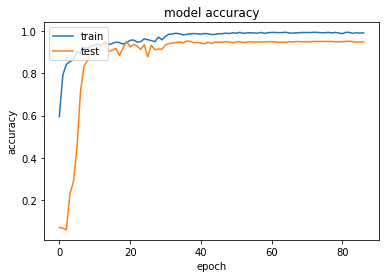

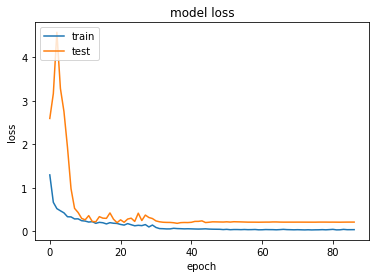

In [17]:
# plot everything
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [18]:
model = tf.keras.models.load_model('best_model_Skel2D.h5')
_, train_accuracy = model.evaluate(X_1, Y)
_, test_accuracy = model.evaluate(X_test_1, Y_test)

1960/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

 - 1s 583us/sample - loss: 0.0081 - acc: 0.9954


840/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [19]:
print('Accuracy on train set: {:.2f}%'.format(100 * train_accuracy))
print('Accuracy on test set: {:.2f}%'.format(100 * test_accuracy))

Accuracy on train set: 99.54%
Accuracy on test set: 95.24%


In [20]:
Y_pred = model.predict(X_test_1)
labels = ['Grab', 'Tap', 'Expand', 'Pinch', 'RC', 'RCC', 'SR', 'SL', 'SU', 'SD', 'SX', 'S+', 'SV', 'Shake']

y_true = []
for i in np.argmax(Y_test,axis=1):
    y_true.append(labels[i])
    
y_pred = []
for i in np.argmax(Y_pred,axis=1):
    y_pred.append(labels[i])

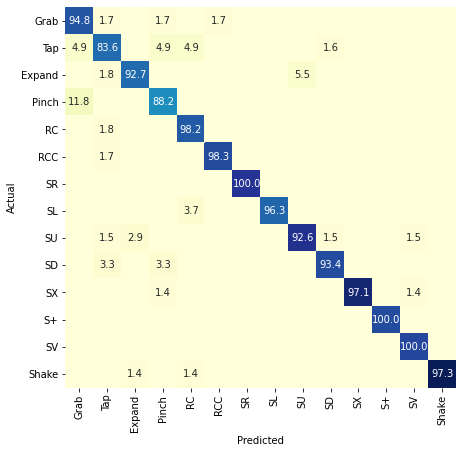

In [21]:
cm_analysis(y_true,y_pred, 'E:\Skelnet2D\data\SHREC\\SHREC_14.png', labels, ymap=None, figsize=(7,7))

In [22]:
Y_pred = model.predict(X_test_1)
labels = ['Grab(1)','Grab(2)', 'Tap(1)', 'Tap(2)','Expand(1)', 'Expand(2)',
          'Pinch(1)', 'Pinch(2)', 'RC(1)', 'RC(2)', 'RCC(1)', 'RCC(2)','SR(1)', 'SR(2)',
          'SL(1)', 'SL(2)','SU(1)', 'SU(2)','SD(1)','SD(2)',
           'SX(1)', 'SX(2)','S+(1)','S+(2)', 'SV(1)', 'SV(2)','Shake(1)','Shake(2)']

y_true = []
for i in np.argmax(Y_test,axis=1):
    y_true.append(labels[i])
    
y_pred = []
for i in np.argmax(Y_pred,axis=1):
    y_pred.append(labels[i])

E:\Skelnet2D\SHREC\utils.py:83: RuntimeWarning: invalid value encountered in true_divide
  cm_perc = cm / cm_sum.astype(float) * 100


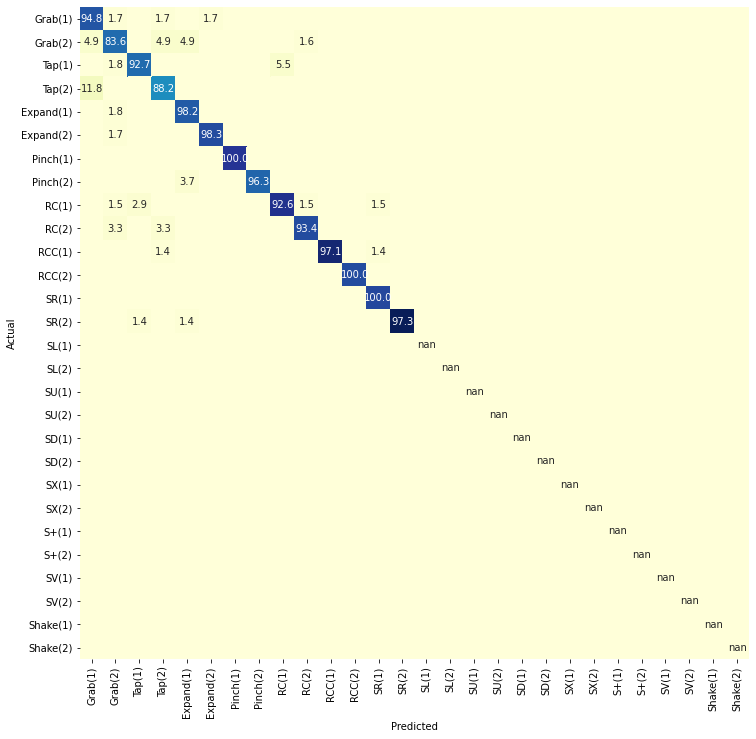

In [23]:
cm_analysis(y_true,y_pred, 'E:\Skelnet2D\data\SHREC\\SHREC_28.png', labels, ymap=None, figsize=(12,12))